In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Weave'))
from Weave.utils import collapse_restore_multiindex
from Weave.inspection import ImportanceData, MapInterface, dotplot, barplot, mapplot, scatterplot

#logging.basicConfig(level = logging.DEBUG)

In [24]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/permimp_val_q0666/'),7, [0,-1,-3,-5,-7,-11,-15,-21,-31])
#perm = ImportanceData(Path('/scistor/ivm/jsn295/permimp_val_q0666/'), [0,1,3,5,7,11,15,21,31], -1)
perm.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/'), X_too = True)
perm.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]
perm.reduce_over('clustid', how = 'max') # Max does not equal sum here. Though it is similar in character (there are no negative importances)
perm.reduce_over('metric', how = 'max')
#perm.df = perm.df.iloc[perm.df.index.get_loc_level('spatcov',level = 'metric')[0],:] # Selecting only one metric
perm.reduce_over('fold', how = 'mean') # Mean equals sum here because the amount of folds is equal.

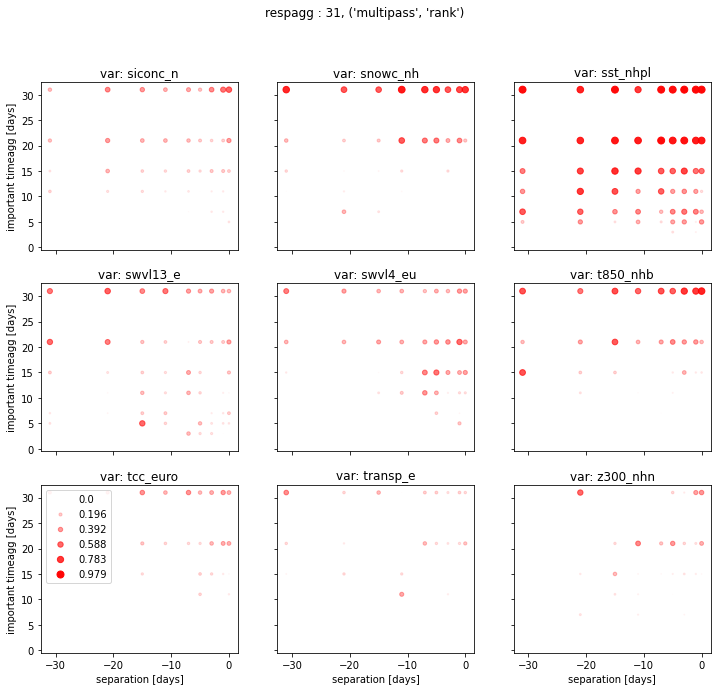

In [23]:
fig, axes = dotplot(perm.df.iloc[:,2], alphascaler = 1, nlegend_items=6)

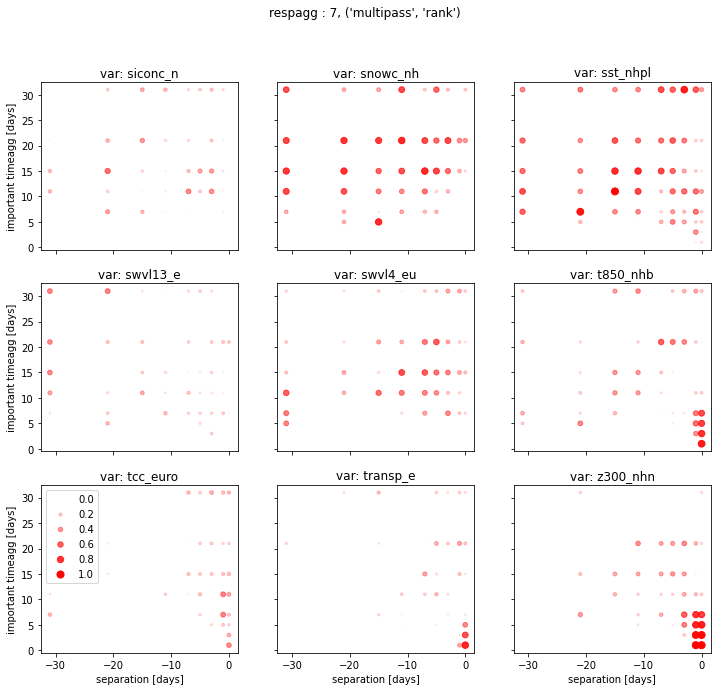

In [27]:
fig, axes = dotplot(perm.df.iloc[:,2], alphascaler = 1, nlegend_items=6)

In [10]:
Xin = perm.X.loc[perm.X.index.get_loc_level('spatcov','metric')[0],:].iloc[:,-1]
# Counting the amount of clusters
groups = list(Xin.index.names)
groups.remove('clustid')
Xin = Xin.groupby(groups).count()
# neccessary for the new cv-approach
groups.remove('fold')
Xin = Xin.groupby(groups).mean()
# Till here
Xin.index = pd.MultiIndex.from_frame(Xin.sort_index().index.to_frame().assign(respagg = 7))
Xin.name = 'mean_number_of_clusters_over_folds'

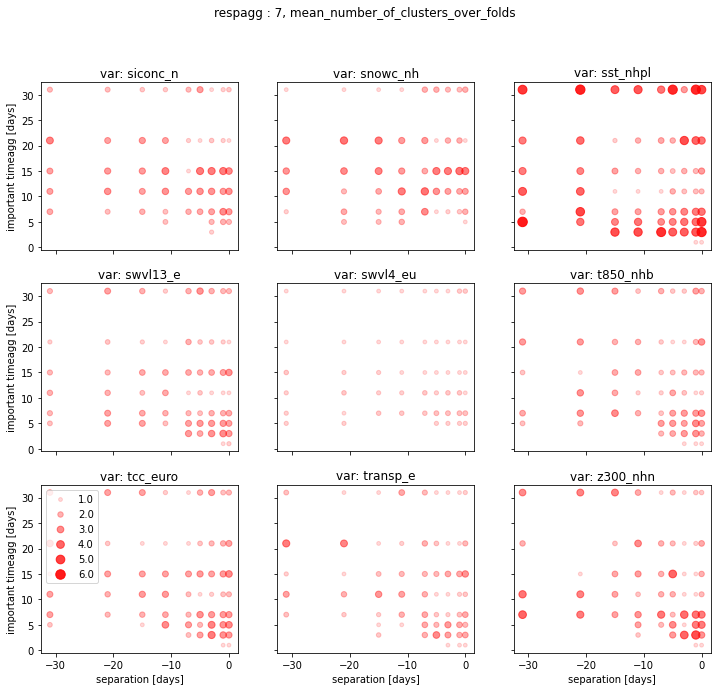

In [15]:
temp = dotplot(Xin, alphascaler = 0.15, nlegend_items=6, sizescaler=15)

In [32]:
shap = ImportanceData(basepath = Path('/scistor/ivm/jsn295/shap_standard_val_q0666/'), respagg = 31, separation = [0,-1,-3,-5,-7,-11,-15,-21,-31])
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/')) # This second path is for the x-variable
shap.global_shap() # Reduces the column (time) axis.
shap.reduce_over('metric', how = 'max')
shap.reduce_over('clustid', how = 'max') # Now max and or sum are doable (we have made absolute the large negative probabilistic influences)
shap.reduce_over('fold', how = 'mean') # Reduce over the folds.

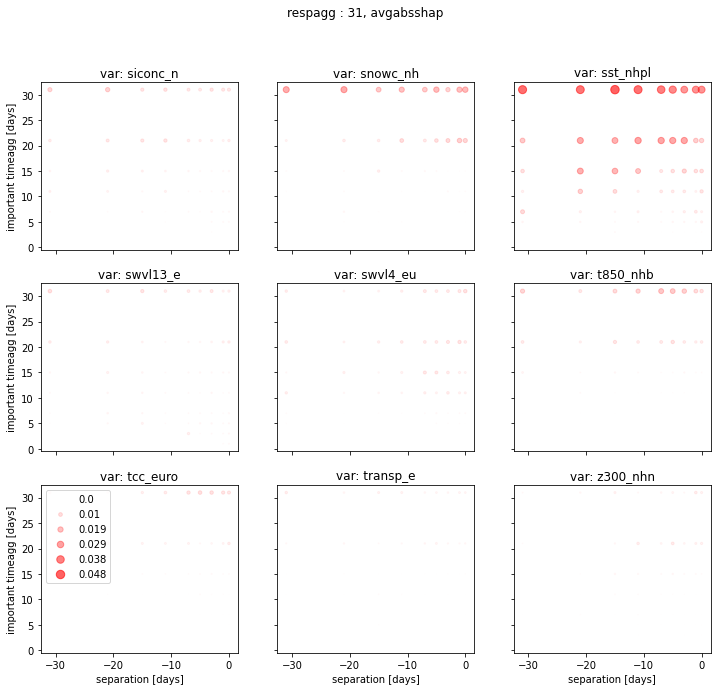

In [33]:
fig, axes = dotplot(shap.df.iloc[:,0], alphascaler = 13, sizescaler=1500, nlegend_items=6)

In [16]:
mapint = MapInterface(corclustpath=Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/'))

Lets investigate the global importance of snowcover at -31. We need the clustids again

In [ ]:
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
shap.global_shap() # Reduces the column axis.
mapresult = mapint.map_to_fields(shap.df.loc[(slice(None),'snowc_nhmin',slice(None),slice(None),-21),:].iloc[:,0])
mapplot(mapresult, wrap_per_row=3)

In [ ]:
mapresult = mapint.map_to_fields(shap.df.loc[(slice(None),'sst_nhplus',slice(None),slice(None),-21),:].iloc[:,0])
mapplot(mapresult, wrap_per_row=3)

Now lets project the sst shap values at -21 for a sample. Reload the data because previously we reduced

In [ ]:
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
imps = shap.df.sort_index(axis = 1).loc[(slice(None),'sst_nhplus',slice(None),slice(None),-21),(slice(None),'2003-07-31')]
imps.columns = imps.columns.droplevel(0)
mapresult = mapint.map_to_fields(imps.iloc[:,0])
mapplot(mapresult, wrap_per_row=3)

1 and 3 day differ greatly in impact and clustering. Lets look what the sst anomalies pattern for them looked like

In [ ]:
mapresult = mapint.get_anoms(imps.loc[(slice(None),slice(None),[3,15]),:], mask_with_clustid=False)
mapplot(mapresult)

In [57]:
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha'))
imps = shap.df.sort_index(axis = 1).loc[:,(slice(None),'2003-07-31')].iloc[:,0]

In [69]:
imps2, oldnames = collapse_restore_multiindex(imps,axis = 0, ignore_level = ['respagg','lag','metric'])
imps2 = imps2.sort_values(ascending=False)

In [ ]:
fig,ax = plt.subplots()
ax.barh(range(10), imps2.iloc[:10])
ax.set_yticks(range(10))
ax.set_yticklabels(imps2.index[:10])
plt.show()

In [3]:
impdf = perm.df.iloc[perm.df.index.get_loc_level(5, 'respagg')[0],:3]

In [ ]:
barplot(impdf)

### Visualizing the number of significant cells
To test the effect of the new partial correlation and significance setup in terms of value and number of cells per variable and such

In [56]:
mapint_par = MapInterface(corclustpath=Path('/scistor/ivm/jsn295/non_cv/correlation_roll_spearman_varalpha/'))
mapint_par.cache_everything()

In [57]:
results = []
for variable in mapint_par.presentvars:
    array = getattr(mapint_par, variable)['correlation']
    n_signif = array.count(['latitude','longitude']).to_dataframe()
    n_signif['n'] = len(array.coords['latitude']) * len(array.coords['latitude'])
    n_signif['max'] = float(array.max())
    n_signif['min'] = float(array.min())
    results.append(n_signif)
results = pd.concat(results, keys = pd.Index(mapint_par.presentvars, name = 'variable'), axis = 0)
results['frac'] = results['correlation'] / results['n']

In [ ]:
timeaggs = [31,21,15,5,1]
fold = None # 1.0
fig, axes = plt.subplots(nrows = 1, ncols = len(timeaggs), sharex = True, sharey = True, figsize = (15,3.5), squeeze = True)
for i, timeagg in enumerate(timeaggs):
    ax = axes[i]
    if not fold is None:
        frame = results.loc[(slice(None),timeagg,slice(None),fold),'frac'].unstack('variable')
    else:
        frame = results.loc[(slice(None),timeagg,slice(None)),'frac'].unstack('variable')
    ax.plot(frame.index.get_level_values('separation'), frame.values)
    ax.set_title(f'timeagg: {timeagg}')
    ax.set_xlabel('separation [days]')
    if i == 0:
        ax.set_ylabel('fraction significant cells')
    if i == (len(timeaggs) - 1):
        ax.legend(frame.columns.values)

### Testing scatterplot of X vs y

In [2]:
shap = ImportanceData(basepath = Path('/scistor/ivm/jsn295/shap_standard_val_q08/'), respagg = 31, separation = [0,-1,-3,-5,-7,-11,-15,-21,-31])
shap.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/'), X_too = True, y_too = True) # This second path is for the x-variable

In [3]:
shap.global_shap()

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab8540a390>]],
       dtype=object))

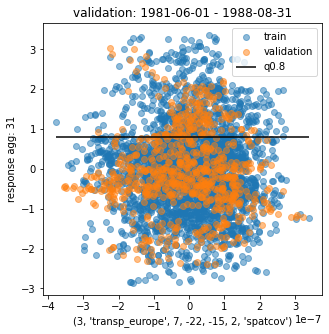

In [6]:
scatterplot(shap, shap.df.iloc[[shap.df.iloc[:,0].argmin()],:], quantile = 0.8)

In [5]:
shap.X

time                                                     1981-06-01  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.031274   
                                                spatcov   -0.303251   
                                        1       mean       3.877896   
                                                spatcov   -0.906956   
2    snowc_nhmin 31      -62 -31        0       mean       4.989387   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.002708   
                                        1       mean       0.010667   
                                                spatcov    0.001023   
                                        2       mean       0.025337   
                                                spatcov    0.000099   

time                                                     1981-06-02  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.273802   
                                                spatcov   -0.336797   
                                        1       mean       4.009231   
                                                spatcov   -0.933497   
2    snowc_nhmin 31      -62 -31        0       mean       5.324197   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001682   
                                        1       mean       0.002889   
                                                spatcov    0.000932   
                                        2       mean       0.027256   
                                                spatcov    0.000105   

time                                                     1981-06-03  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.446171   
                                                spatcov   -0.364802   
                                        1       mean       4.118871   
                                                spatcov   -0.949060   
2    snowc_nhmin 31      -62 -31        0       mean       5.648336   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001397   
                                        1       mean      -0.008257   
                                                spatcov    0.000955   
                                        2       mean       0.030068   
                                                spatcov   -0.000005   

time                                                     1981-06-04  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.532743   
                                                spatcov   -0.384611   
                                        1       mean       4.220785   
                                                spatcov   -0.958956   
2    snowc_nhmin 31      -62 -31        0       mean       5.960511   
...                                                             ...   
4    tcc_europe  31      -31  0         0       spatcov   -0.001535   
                                        1       mean      -0.017310   
                                                spatcov    0.000842   
                                        2       mean       0.028210   
                                                spatcov   -0.000075   

time                                                     1981-06-05  \
fold variable    timeagg lag separation clustid metric                
3    snowc_nhmin 31      -62 -31        0       mean       1.529200   
                                                spatcov   -0.395107   
                    

In [2]:
perm = ImportanceData(Path('/scistor/ivm/jsn295/permimp_val_q0666/'), respagg = 31, separation = -15)
perm.load_data(inputpath = Path('/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/'), X_too = True, y_too = True)
perm.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]

(<Figure size 288x288 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7b8ceeb8>]],
       dtype=object))

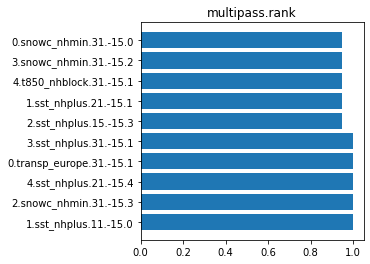

In [3]:
barplot(perm.df.iloc[:,2])

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7fe89748>]],
       dtype=object))

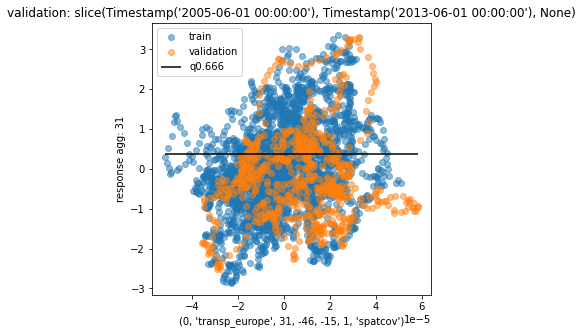

In [5]:
scatterplot(perm, perm.df.iloc[[perm.df.iloc[:,2].argmax()],:], quantile = 0.666)

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab850c3160>]],
       dtype=object))

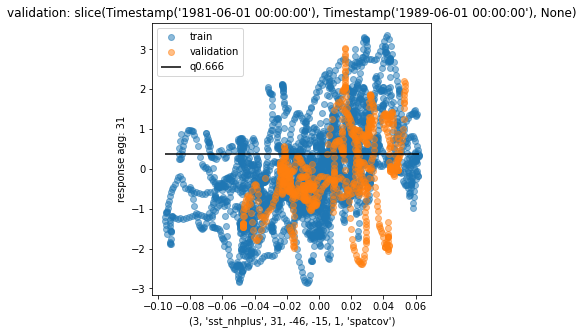

In [13]:
scatterplot(perm, perm.df.loc[([31],[3],['sst_nhplus'],[31],slice(None),slice(None),[1]),:], quantile = 0.666)

(<Figure size 360x360 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab7b8fca90>]],
       dtype=object))

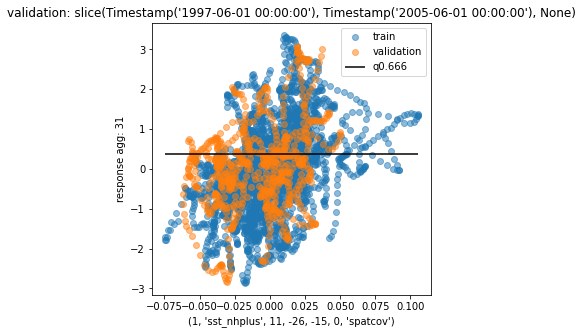

In [14]:
scatterplot(perm, perm.df.loc[([31],[1],['sst_nhplus'],[11],slice(None),[-15],[0]),:], quantile = 0.666)